## Packages

In [1]:

import matplotlib.pyplot as plt
from numpy import full, empty, linspace, eye
from sympy import Matrix

from helper_functions import (
    make_hamiltonian,
    calculate_probability,
)

## Parameters
Adjustable values

In [2]:
flavors = 2 #Number of neutrino flavor states (2-4)

ticks = 100 #How many intervals will energy be divided into

steps = 50 #How many intervals will distance be divided into

distance = 100 #Total distance traveled by Neutrino

#Range of energies to analyze
energy_range_start = 3*10**(-3)
energy_range_end = 10**(-2)

#(0,1,2,3) -> Electron, muon, tau, and sterile neutrino flavor states, respectively
start_state = 1
end_state = 0

potential_range = True #True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
sterile_potential = False #Determines if potential is applied to the electron neutrino or the sterile neutrino
potentials = [-0.02,-0.01,0,0.01,0.02]
#potentials = [-0.1,-0.05,0,0.05,0.1]

## probability_plotter

# Generates plots of energy vs probability
# Params:
 hamiltonian: matrix for hamiltonian
  
 potential_values: list of potentials at different distances: list must have length of distance or 1 with potential_range = False, length of any size for potential_range = True

 energy_values: range of energies to plot
 
 distance: total length traveled by neutrino
 
 nu_I: Starting neutrino flavor state
 
 nu_F: Detected neutrino flavor state
 
 steps: The number of intervals distance will be divided into
 
 symbols: dictionary containing symbols for theta angles, phase angles, neutrino masses, energy, and potential
 
 potential_range: True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
 
# Returns:
 None

In [3]:


def probability_plotter(hamiltonian:Matrix,
                        flavors:int,
                        energy_values:list,
                        potential_values:list,
                        distance:int,nu_I:list,
                        nu_F:list,
                        steps:int,  
                        potential_range:bool=False) -> None:
    
    #hamiltonian = lambdify([symbols['Energy'],symbols['A']],hamiltonian)
    step_size = distance / steps

    y = [] #array containing probabilities of the neutrino at energy[i]
    
    if not potential_range:
        for energy_value in energy_values: #Iterates over all energy values to calculate a curve for probability as a function of energy
            y.append(calculate_probability(hamiltonian,energy_value,full(steps,potential_values),step_size,nu_I,nu_F,steps))
    else:
        ylist = empty((len(potential_values), len(energy_values)))
    
        for j, energy_value in enumerate(energy_values):#Iterates over all energy values to calculate a curve for probability as a function of energy
            i = 0
            for i, potential_value in enumerate(potential_values):#Iterates over each potential to calculate a different curve for probability as a function of energy depending on potential
                ylist[i,j] = calculate_probability(hamiltonian,energy_value,[potential_value]*steps,step_size,nu_I,nu_F,steps)
                
    fig, ax = plt.subplots(1,1,figsize = (12,4))
    axs = [ax]

    xlabel = r"$Energy$"
    ylabel = r"$Probability$"
    
    if potential_range == True: #Plots every curve created of potential_range = True
        
        #axs[0].plot(energy_values,[y for y in ylist.transpose()])
        for curve in ylist:
            axs[0].plot(energy_values, curve)
        
        potential_range_label = [p for p in potential_values]
        leg2 = axs[0].legend(potential_range_label,loc = "upper right")
        axs[0].add_artist(leg2)
    else: #else, plots the single curve created
        axs[0].plot(energy_values,y)        
      
    axs[0].legend([str(flavors) + "x" + str(flavors) + " Hamiltonian"],loc = "upper left")
    
    axs[0].set_xlabel(xlabel+" (GeV)")
    axs[0].set_ylabel(ylabel)
    axs[0].set_title(ylabel + " vs " + xlabel)

## start
# Initializes program
# Params:

flavors: number of neutrino flavor states used. Can range between 2-4

energy_range_start: start of the range of energies to plot

energy_range_end: end of the range of energies to plot

potential_values: list of potentials at different distances: list must have length of distance or 1 with potential_range = False, length of any size for potential_range = True

distance: total length traveled by neutrino

start_state: Starting neutrino flavor state; (0,1,2,3) -> Electron, muon, tau, and sterile neutrino flavor states, respectively

end_state: Detected neutrino flavor state; (0,1,2,3) -> Electron, muon, tau, and sterile neutrino flavor states, respectively


steps: The number of intervals distance will be divided into

symbols: dictionary containing symbols for theta angles, phase angles, neutrino masses, energy, and potential

potential_range: True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
# Returns:
None

In [4]:


def start(flavors:int,
          energy_range_start:float,
          energy_range_end:float,
          potential_values:list,
          distance:int,
          start_state:int,
          end_state:int,
          steps:int,
          potential_range:bool =False,
          sterile_potential:bool = False) -> None:

    #Asserts check for correct inputs
    if flavors < 2 or flavors > 4:
        raise ValueError('Flavor must be 2-4')
    if energy_range_start >= energy_range_end:
        raise ValueError('energy_range_end must be greater than energy_range_start')
    if not isinstance(potential_values, list):
        raise ValueError('potential values must be a list. to use a constant value with potential_values == False, input [value]')
    #Checks for correct dimensions of potential_values
    if not ((len(potential_values) ==1 or len(potential_values) == distance) or potential_range):
        raise ValueError('must have potential_range or len(potential_values) in (1,distance)')
    if not isinstance(distance, int):
        raise ValueError('distance must be an integer')
    if distance <= 0:
        raise ValueError('distance must be greater than 0')
    if not isinstance(start_state,int):
        raise ValueError('start_state must be an integer')
    if not isinstance(end_state,int):
        raise ValueError('end_state must be an integer')
    if not isinstance(steps,int):
        raise ValueError('steps must be an integer')
    if not isinstance(potential_range, bool):
        raise ValueError('potential_range must be a boolean')
    if not isinstance(potential_range, bool):
        raise ValueError('sterile_potential must be a boolean')
    
    #Generates symbolic variables to use for quick calculations
    
    #Starting and ending neutrino states in the flavor basis
    nu_I = eye(4)[start_state].tolist()
    nu_F = eye(4)[end_state].tolist()

    
    energy_values = list(linspace(energy_range_start,energy_range_end,num =ticks))

    hamiltonian = make_hamiltonian(flavors,sterile_potential) #Generates hamiltonian for the neutrino
    
    probability_plotter(hamiltonian,flavors,energy_values,potential_values,distance,nu_I,nu_F,steps, potential_range)
    

## Execution

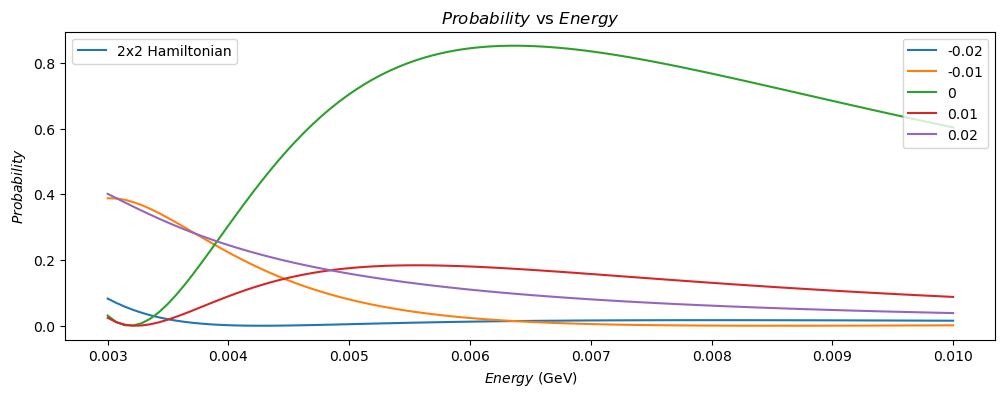

In [5]:
start(flavors,energy_range_start,energy_range_end,potentials,distance,start_state,end_state,steps,potential_range,sterile_potential)